### Упражнение 1
* Реализуйте функцию `get_geodesic_distance`, рассчитывающее геодезическое расстояние между двумя точками в километрах.

In [668]:
import numpy as np
import pandas as pd
import geopandas as gpd
import random
from shapely.geometry import Polygon, Point, LineString
import matplotlib.pyplot as plt
import folium
%matplotlib inline

In [669]:
# Функция, рассчитывающая геодезическое расстояние между двумя точками в километрах
# Использует модуль haversine
from haversine import haversine
def get_geodesic_distance_haversine_native(p1, p2):
    return haversine((p1.x, p1.y), (p2.x, p2.y), unit='km')

In [670]:
# Функция, рассчитывающая геодезическое расстояние между двумя точками в километрах
# Использует формулу Хаверсина
from math import radians, cos, sin, asin, sqrt
def get_geodesic_distance(p1, p2):
    # Перевод координат в радианы
    s1, l1, s2, l2 = map(radians, [p1.x, p1.y, p2.x, p2.y])
    latitude = s2 - s1 
    longitude = l2 - l1 
    a = sin(latitude/2)**2 + cos(l1) * cos(l2) * sin(longitude/2)**2
    c = 2 * asin(sqrt(a))
    # Переводим угловое расстояние в километры, умножая на радиус Земли
    r = 6371 * c 
    return r

In [671]:
# Сигнатура функции и пример вывода:

mipt = Point(55.9297243, 37.5199434) 
kremlin = Point(55.752023, 37.6174994)

get_geodesic_distance_haversine_native(mipt, kremlin)

20.676980556006196

In [672]:
# Сигнатура функции и пример вывода:

mipt = Point(55.9297243, 37.5199434) 
kremlin = Point(55.752023, 37.6174994)

get_geodesic_distance(mipt, kremlin)

21.54914185678717

### Упражнение 2

* Реализуйте функцию `get_k_nearest_neighbours_by_dist`, осуществляющую поиск `k` ближайших соседей полигона из заданного списка на основе геодезического расстояния. Добавьте две возможности учета расстояния: через ближайшие точки на границах полигонов и через центроиды полигонов.

In [673]:
# Функция осуществляет поиск k ближайших соседей полигона из заданного списка 
# на основе геодезического расстояния
from shapely.ops import nearest_points
def get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_centroid'):
    # Code here
    ps = gpd.GeoDataFrame()
    ps['geometry'] = gpd.GeoSeries(polygons)
    if kind == 'by_centroid':
        centr_polygon = polygon.centroid
        ps['centr_polygons'] = ps.centroid
        ps['dist'] = [get_geodesic_distance_haversine_native(centr_polygon, x) for x in ps['centr_polygons']]
        ps = ps[ps['dist'] != 0.0]
        ps = ps.sort_values('dist')[:10].reset_index()
        ps.drop(columns='centr_polygons', inplace=True)
    elif kind == 'by_board':
        ps['nearest_points'] = [nearest_points(polygon, p) for p in polygons]
        ps['dist'] = [get_geodesic_distance_haversine_native(x[0], x[1]) for x in ps['nearest_points']]
        ps = ps[ps['geometry'] != polygon]
        ps = ps.sort_values('dist')[:10].reset_index()
        ps.drop(columns='nearest_points', inplace=True)
    else:
        return print('method not defined')
    return ps.reindex(columns=['dist', 'geometry'])

In [674]:
# Сигнатура функции и пример вывода:

big_moscow_districts = gpd.read_file('./data/big_moscow_disticts/big_moscow_districts.shp')
polygon = random.sample(big_moscow_districts['geometry'].tolist(), 1)[0]
#polygons = random.sample(big_moscow_districts['geometry'].tolist(), len(big_moscow_districts['geometry'].tolist()))
polygons = random.sample(big_moscow_districts['geometry'].tolist(), 146)

k_nearest_neighbours_by_board = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_board')
k_nearest_neighbours_by_centroid = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_centroid')
#k_nearest_neighbours_by_centroid
#polygon
#k_nearest_neighbours_by_board

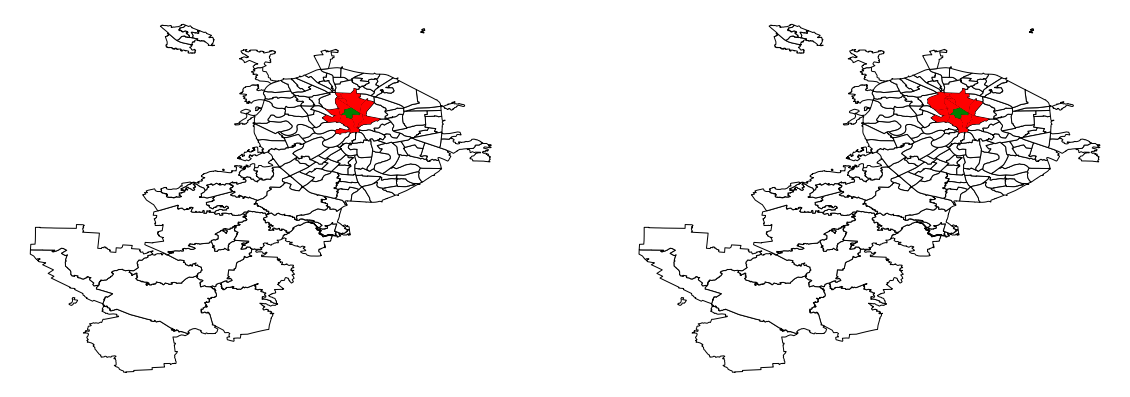

In [675]:
###

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_centroid.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_board.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

### Упражнение 3 (*)
* Реализуйте функцию `spatial_resample`, выполняющую пространственное агрегирование. 
  На вход функция принимает:
  - `init_polygons` - изначальное гео-разбиение
  - `agg_polygons` - новое гео-разбиение, по которому будет проводится пространственное агрегирование
  - `column` - название столбца количественной переменной в `init_polygons`, которая будет агрегирована  
  - `method` - метод аггрегирования: `sum` - сумма значений, `mean` - среднее значение
  - `kind` - способ аггрегирования при частичном пересечении полигонов из `agg_polygons` и `init_polygons`, `max` - отнести значение в `column` к полигону из `agg_polygons` с которым площадь пересечения максимальна, `prop` - разбить значение в `column` пропорционально площадям пересечений

In [728]:
# Пространственное агрегатирование
def spatial_resample(agg_polygons, init_polygons, method, column, kind):
    pm = gpd.GeoDataFrame()
    pm = gpd.overlay(init_polygons, agg_polygons, how='identity')
    pm = pm.dropna()
    pm['area'] = pm.area
    if kind == 'prop':
        pm['calc'] = pm.groupby('FID_1')['area'].transform(sum)
        pm[column] = pm[column] * pm['area']/pm['calc']
    elif kind == 'max':
        pm['calc'] = pm.groupby('FID_1')['area'].transform(max)
        pm = pm.loc[pm['area'] == pm['calc']]
    else:
        return print('Unknown kind')
    if method == 'mean':
        pm = gpd.GeoDataFrame(pm.groupby('FID_2')[column].mean())
    elif method == 'sum':
        pm = gpd.GeoDataFrame(pm.groupby('FID_2')[column].sum())
    else:
        return print('Unknown method')
    pm = agg_polygons.merge(pm, left_on='FID', right_on='FID_2', suffixes=('_0', '_1'))
    pm['FID'] = pm['FID'].astype('str')
    return pm

In [729]:
# Сигнатура функции и пример вывода:

grid_big_moscow = gpd.read_file('./data/grid_big_moscow/grid_big_moscow.shp')
grid_big_moscow.crs = "EPSG:4326"  
grid_big_moscow['random_value'] = np.random.randint(0, 100, len(grid_big_moscow))

mean_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                        method='mean', column='random_value', kind='prop')
sum_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                      method='sum', column='random_value', kind='max')


<ipython-input-728-9303eaf0be2d>:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pm['area'] = pm.area
<ipython-input-728-9303eaf0be2d>:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pm['area'] = pm.area


In [730]:
#fig = plt.figure(figsize=(20, 20))
#ax = plt.gca()
sum_resample_table #.plot(ax=ax)

FID                                           geometry  random_value
0      0  POLYGON ((37.68525 55.89508, 37.68891 55.89504...          1288
1      1  POLYGON ((37.60716 55.87932, 37.60754 55.87911...           564
2      2  POLYGON ((37.64437 55.89768, 37.65226 55.89678...          1475
3      3  POLYGON ((37.49625 55.89248, 37.49851 55.89347...          1809
4      4  POLYGON ((37.41143 55.87096, 37.40632 55.87426...          2683
..   ...                                                ...           ...
141  141  MULTIPOLYGON (((37.31548 55.61297, 37.31545 55...          2865
142  142  POLYGON ((37.13243 55.59919, 37.13442 55.60066...          2399
143  143  POLYGON ((37.78505 55.61682, 37.78475 55.61683...          1625
144  144  POLYGON ((37.64065 55.61046, 37.63994 55.61011...          1627
145  145  POLYGON ((37.58598 55.63117, 37.58588 55.63087...          5231

[146 rows x 3 columns]

In [731]:
#fig = plt.figure(figsize=(20, 20))
#ax = plt.gca()
mean_resample_table #.plot(ax=ax)

FID                                           geometry  random_value
0      0  POLYGON ((37.68525 55.89508, 37.68891 55.89504...     31.070784
1      1  POLYGON ((37.60716 55.87932, 37.60754 55.87911...     31.554126
2      2  POLYGON ((37.64437 55.89768, 37.65226 55.89678...     34.873683
3      3  POLYGON ((37.49625 55.89248, 37.49851 55.89347...     41.654543
4      4  POLYGON ((37.41143 55.87096, 37.40632 55.87426...     50.509907
..   ...                                                ...           ...
141  141  MULTIPOLYGON (((37.31548 55.61297, 37.31545 55...     31.928513
142  142  POLYGON ((37.13243 55.59919, 37.13442 55.60066...     40.137572
143  143  POLYGON ((37.78505 55.61682, 37.78475 55.61683...     34.369848
144  144  POLYGON ((37.64065 55.61046, 37.63994 55.61011...     35.411325
145  145  POLYGON ((37.58598 55.63117, 37.58588 55.63087...     40.780471

[146 rows x 3 columns]

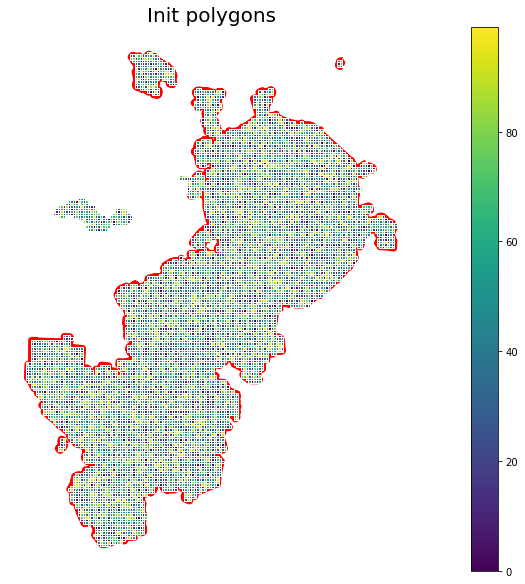

In [732]:
fig = plt.figure(figsize=(20, 10))
plt.title('Init polygons', fontsize=20)
ax = plt.gca()
big_moscow_districts.plot(ax=ax, color='white', edgecolor='red', linewidth = 7)
grid_big_moscow.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

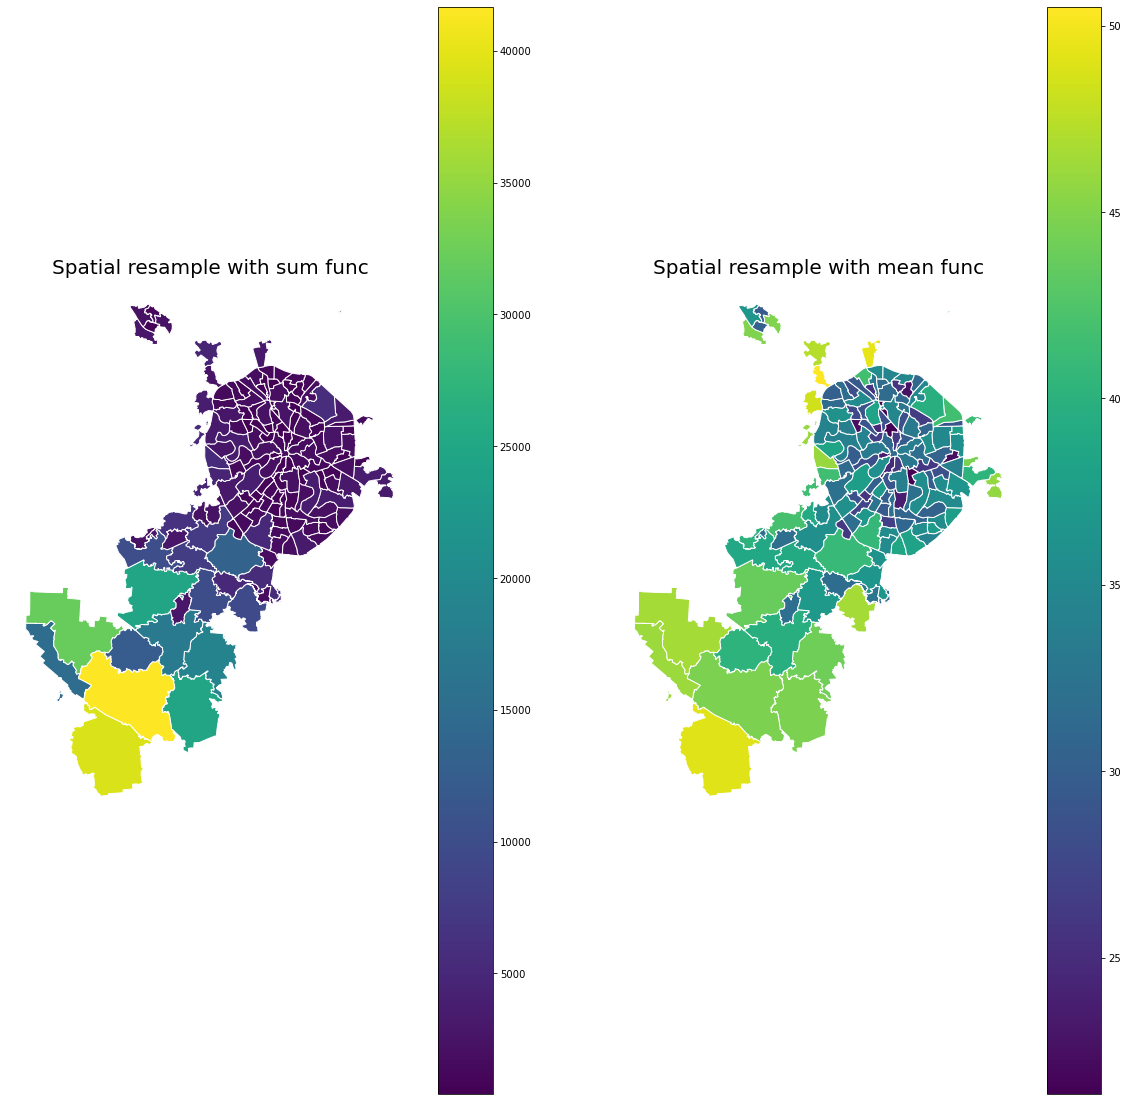

In [733]:
###

fig = plt.figure(figsize=(20, 20))

ax = plt.subplot(1, 2, 1)
plt.title('Spatial resample with sum func', fontsize=20)
sum_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
plt.title('Spatial resample with mean func', fontsize=20)
mean_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

### Упражнение 4
* Отобразите результаты упражнений 2 и 3 (рисунки с `###`) на интерактивной карте в `Folium`

In [734]:
# Задача 2
# Отобразим районы, найденные по границам на карте
m = folium.Map(location=[polygon.centroid.y, polygon.centroid.x], 
               zoom_start=11)

m.choropleth(polygon, fill_color='green')
[m.choropleth(x, fill_color='red')for x in k_nearest_neighbours_by_board['geometry']]
m

/Users/alekseimaliutin/opt/anaconda3/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [735]:
# Задача 2
# Отобразим районы, найденные по центроидам на карте
m = folium.Map(location=[polygon.centroid.y, polygon.centroid.x], 
               zoom_start=11)

m.choropleth(polygon, fill_color='green')
[m.choropleth(x, fill_color='red')for x in k_nearest_neighbours_by_centroid['geometry']]
m

In [744]:
# Задача 3
# Отобразим агрегатирование по методу sum
p = sum_resample_table.unary_union
m = folium.Map(location=[p.centroid.y, p.centroid.x], 
               zoom_start=9)
folium.Choropleth(
    geo_data=sum_resample_table,
    name='sum resample',
    data=sum_resample_table,
    columns=['FID', 'random_value'],
    key_on='feature.id',
    fill_color='RdYlGn',
    fill_opacity=0.9,
    line_opacity=0.1
).add_to(m)

folium.LayerControl().add_to(m)
m

In [743]:
# Задача 3
# Отобразим агрегатирование по методу mean
p = mean_resample_table.unary_union
m = folium.Map(location=[p.centroid.y, p.centroid.x], 
               zoom_start=9)
folium.Choropleth(
    geo_data=mean_resample_table,
    name='mean resample',
    data=mean_resample_table,
    columns=['FID', 'random_value'],
    key_on='feature.id',
    fill_color='BrBG',
    fill_opacity=0.9,
    line_opacity=0.1
).add_to(m)

folium.LayerControl().add_to(m)
m